# Training PPO with Vector Envs and Domain Randomization 3D setting


------------------------------


## Importing required libraries

In [1]:

from __future__ import annotations

import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm

import gymnasium as gym
from gymnasium.vector import AsyncVectorEnv, SyncVectorEnv
from gymnasium.wrappers.vector import RecordEpisodeStatistics, FlattenObservation
# Ensure gym is installed
#%pip install gym

import gymnasium_env
from gymnasium_env import PPO

from gymnasium.envs.registration import register
from gymnasium.utils import seeding

gym.pprint_registry()

===== classic_control =====
Acrobot-v1             CartPole-v0            CartPole-v1
MountainCar-v0         MountainCarContinuous-v0 Pendulum-v1
===== phys2d =====
phys2d/CartPole-v0     phys2d/CartPole-v1     phys2d/Pendulum-v0
===== box2d =====
BipedalWalker-v3       BipedalWalkerHardcore-v3 CarRacing-v3
LunarLander-v3         LunarLanderContinuous-v3
===== toy_text =====
Blackjack-v1           CliffWalking-v0        FrozenLake-v1
FrozenLake8x8-v1       Taxi-v3
===== tabular =====
tabular/Blackjack-v0   tabular/CliffWalking-v0
===== mujoco =====
Ant-v2                 Ant-v3                 Ant-v4
Ant-v5                 HalfCheetah-v2         HalfCheetah-v3
HalfCheetah-v4         HalfCheetah-v5         Hopper-v2
Hopper-v3              Hopper-v4              Hopper-v5
Humanoid-v2            Humanoid-v3            Humanoid-v4
Humanoid-v5            HumanoidStandup-v2     HumanoidStandup-v4
HumanoidStandup-v5     InvertedDoublePendulum-v2 InvertedDoublePendulum-v4
InvertedDoublePendulu

In [4]:
env = gym.make("GridWorld-v0", max_episode_steps= 500, render_mode="human")
print(env)

<TimeLimit<OrderEnforcing<PassiveEnvChecker<GridWorldEnv<GridWorld-v0>>>>>


In [5]:
print(env.observation_space)
print(env.action_space)
print(env.observation_space.shape)

Dict('agent': Box(0, 49, (2,), int32), 'target': Box(0, 49, (2,), int32))
Discrete(4)
None


In [ ]:
q = np.zeros(50, env.action_space.n)
print(q.shape)
episodes = 3

rewards_per_episode = np.zeros(episodes)

learning_rate_a =  0.9
discount_factor_g = 0.9


epsilon = 1
epsilon_decay_rate = 0.0001
rng = np.random.default_rng()

for i in range(episodes):


    state,info = env.reset()
    terminated = False
    truncated = False

    print("observation space:", env.observation_space)
    print("action space:", env.action_space)
    print("observation:", state)
    print("info:", info)


    while (not terminated and not truncated):
        if rng.random() < epsilon:
            action = env.action_space.sample()  # agent policy that uses the observation and info
        else:
            action = np.argmax(q[state,:])
        new_state, reward, terminated, truncated, info = env.step(action)
        q[state,action] = q[state,action] + learning_rate_a*(reward + discount_factor_g * np.max(q[new_state,:]) - q[state,action])
    
        #env.render()

        episode_over = terminated or truncated
        state = new_state

epsilon = max(epsilon -epsilon_decay_rate, 0)  # decay epsilon
    
if(epsilon ==0):
    learning_rate_a = 0.0001

if reward == 1:
    rewards_per_episode[i] = 1

env.close()

sum_rewards = np.zeros(episodes)
for t in range(episodes):
    sum_rewards[t] = np.sum(rewards_per_episode[max(0,t-100):(t+1)])
plt.plot(sum_rewards)


# Proximal Policy Optimization using Vectorize Environments

## Environment Creation Randozimation

----------------------

Randomly generating the parameters for 3 parallel 'LunarLander-v3' envs, using `np.clip` to stay in the recommended parameter space:




In [2]:
env = gym.make("GridWorld3D-v0")
print(env)

<OrderEnforcing<PassiveEnvChecker<GridWorld3DEnv<GridWorld3D-v0>>>>


### Synchronous Vectorization

In [3]:
# Define the function that will create each individual environment
def make_env():
    return gym.make("GridWorld3D-v0", max_episode_steps=800)

# Create a SyncVectorEnv with 6 parallel environments
envs = SyncVectorEnv([lambda: make_env() for _ in range(6)])

# Verify the environment
envs

SyncVectorEnv(num_envs=6)

## Setup

In [4]:
#environment hyperparameters
n_envs = 6
n_updates = 1000
n_steps_per_update = 64


In [5]:
# agent hyperparams
gamma = 0.999
lam = 0.95  # hyperparameter for GAE
ent_coef = 0.01  # coefficient for the entropy bonus (to encourage exploration)
actor_lr = 0.001
critic_lr = 0.005
n_features = 4

In [6]:
# set the device
use_cuda = False
if use_cuda:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")

### Print Environment Spaces

In [7]:
# Access the observation space of the wrapped environment
obs_space = envs.observation_space
print("Observation space:", obs_space)

# Access the action space of the wrapped environment
action_space = envs.action_space
print("Action space:", action_space)

# Access the individual spaces of the observation dictionary
agent_space = obs_space["agent"]
target_space = obs_space["target"]
print("Agent space:", agent_space)
print("Target space:", target_space)

Observation space: Dict('agent': Box(0.0, 50.0, (6, 3), float32), 'target': Box(0.0, 50.0, (6, 3), float32))
Action space: Box(-1.0, 1.0, (6, 3), float32)
Agent space: Box(0.0, 50.0, (6, 3), float32)
Target space: Box(0.0, 50.0, (6, 3), float32)


## Initialized The Agent

In [8]:
envs = FlattenObservation(envs)
obs_shape = envs.single_observation_space.shape[0]
action_shape = envs.single_action_space.shape[0]
print("Observation shape:", obs_shape)
print("Action shape:", action_shape)   
print(envs.single_observation_space)

Observation shape: 6
Action shape: 3
Box(0.0, 50.0, (6,), float32)


In [9]:
envs

<FlattenObservation, SyncVectorEnv(num_envs=6)>

In [10]:
# Ensure PPO is correctly imported and callable
from gymnasium_env.PPO import PPO

# init the agent
agent = PPO(obs_shape, action_shape, device, critic_lr, actor_lr, n_envs)
print(agent)

PPO(
  (critic): Sequential(
    (0): Linear(in_features=6, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
  (actor): Sequential(
    (0): Linear(in_features=6, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=3, bias=True)
  )
)


# Training the  PPO Agent

## PPO

For our training loop, we are using the `RecordEpisodeStatistics` wrapper to record the episode lengths and returns and we are also saving
the losses and entropies to plot them after the agent finished training.

You may notice that we don't reset the vectorized envs at the start of each episode like we would usually do.
This is because each environment resets automatically once the episode finishes (each environment takes a different number of timesteps to finish
an episode because of the random seeds). As a result, we are also not collecting data in `episodes`, but rather just play a certain number of steps
(`n_steps_per_update`) in each environment (as an example, this could mean that we play 20 timesteps to finish an episode and then
use the rest of the timesteps to begin a new one).




In [11]:
envs

<FlattenObservation, SyncVectorEnv(num_envs=6)>

In [12]:
envs = RecordEpisodeStatistics(envs)
envs

<RecordEpisodeStatistics, <FlattenObservation, SyncVectorEnv(num_envs=6)>>

In [13]:
critic_losses = []
actor_losses = []
entropies = []

# use tqdm to get a progress bar for training
for sample_phase in tqdm(range(n_updates)):
    # we don't have to reset the envs, they just continue playing
    # until the episode is over and then reset automatically

    # reset lists that collect experiences of an episode (sample phase)
    ep_value_preds = torch.zeros(n_steps_per_update, n_envs, device=device)
    ep_rewards = torch.zeros(n_steps_per_update, n_envs, device=device)
    ep_action_log_probs = torch.zeros(n_steps_per_update, n_envs, device=device)
    masks = torch.zeros(n_steps_per_update, n_envs, device=device)

    # at the start of training reset all envs to get an initial state
    
    if sample_phase == 0:
        states, info = envs.reset(seed=42)
    
    # play n steps in our parallel environments to collect data
    for step in range(n_steps_per_update):
        # select an action A_{t} using S_{t} as input for the agent
        actions, action_log_probs, state_value_preds, entropy = agent.select_action(
            states
        )

        # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
        states, rewards, terminated, truncated, infos = envs.step(
            actions.cpu().numpy()
        )

        ep_value_preds[step] = torch.squeeze(state_value_preds)
        ep_rewards[step] = torch.tensor(rewards, device=device)
        ep_action_log_probs[step] = action_log_probs

        # add a mask (for the return calculation later);
        # for each env the mask is 1 if the episode is ongoing and 0 if it is terminated (not by truncation!)
        masks[step] = torch.tensor([not term for term in terminated])

    # calculate the losses for actor and critic
    critic_loss, actor_loss = agent.get_losses(
        ep_rewards,
        ep_action_log_probs,
        ep_value_preds,
        entropy,
        masks,
        gamma,
        lam,
        ent_coef,
        device,
    )

    # update the actor and critic networks
    agent.update_parameters(critic_loss, actor_loss)

    # log the losses and entropy
    critic_losses.append(critic_loss.detach().cpu().numpy())
    actor_losses.append(actor_loss.detach().cpu().numpy())
    entropies.append(entropy.detach().mean().cpu().numpy())

100%|██████████| 1000/1000 [01:09<00:00, 14.45it/s]


## Plotting

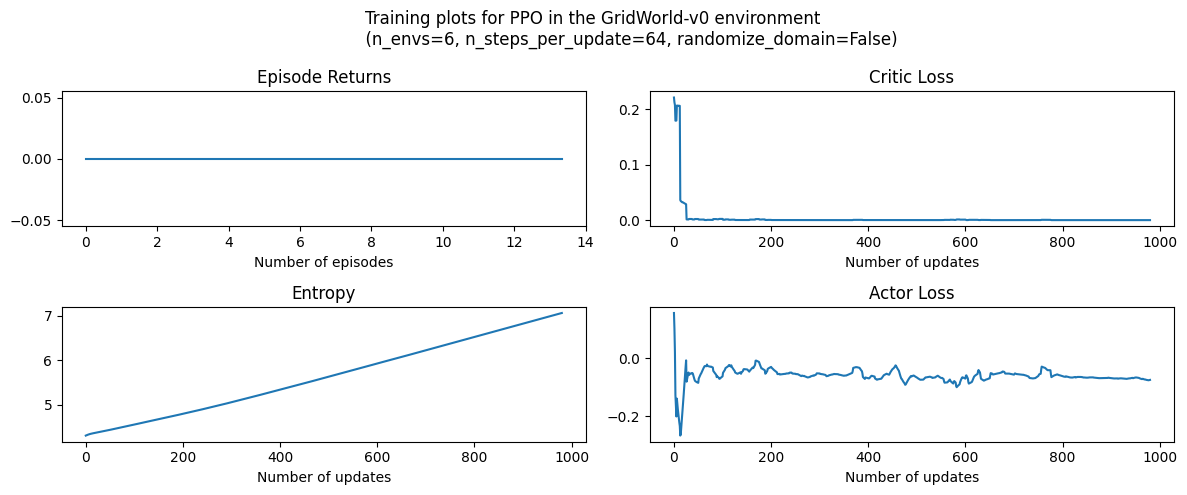

In [14]:
""" plot the results """

# %matplotlib inline
randomize_domain = False
rolling_length = 20
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 5))
fig.suptitle(
    f"Training plots for {agent.__class__.__name__} in the GridWorld-v0 environment \n \
             (n_envs={n_envs}, n_steps_per_update={n_steps_per_update}, randomize_domain={randomize_domain})"
)

# episode return
axs[0][0].set_title("Episode Returns")
episode_returns_moving_average = (
    np.convolve(
        np.array(envs.return_queue).flatten(),
        np.ones(rolling_length),
        mode="valid",
    )
    / rolling_length
)
axs[0][0].plot(
    np.arange(len(episode_returns_moving_average)) / n_envs,
    episode_returns_moving_average,
)
axs[0][0].set_xlabel("Number of episodes")

# entropy
axs[1][0].set_title("Entropy")
entropy_moving_average = (
    np.convolve(np.array(entropies), np.ones(rolling_length), mode="valid")
    / rolling_length
)
axs[1][0].plot(entropy_moving_average)
axs[1][0].set_xlabel("Number of updates")


# critic loss
axs[0][1].set_title("Critic Loss")
critic_losses_moving_average = (
    np.convolve(
        np.array(critic_losses).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0][1].plot(critic_losses_moving_average)
axs[0][1].set_xlabel("Number of updates")


# actor loss
axs[1][1].set_title("Actor Loss")
actor_losses_moving_average = (
    np.convolve(np.array(actor_losses).flatten(), np.ones(rolling_length), mode="valid")
    / rolling_length
)
axs[1][1].plot(actor_losses_moving_average)
axs[1][1].set_xlabel("Number of updates")

plt.tight_layout()
plt.show()

# Agent Evaluation

In [ ]:
""" play a couple of showcase episodes """
n_showcase_episodes = 6

for episode in range(n_showcase_episodes):
    print(f"starting episode {episode}...")

    env = gym.make("GridWorld3D-v0", render_mode = "human", max_episode_steps=500)

    env = gym.wrappers.FlattenObservation(env)
    # get an initial state
    state, info = env.reset()
    print(state)
    print(env)

    # play one episode
    done = False
    while not done:
        # select an action A_{t} using S_{t} as input for the agent
        with torch.no_grad():
            action, _, _, _ = agent.select_action(state[None,:])
        # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
        state, reward, terminated, truncated, info = env.step(action.detach().cpu().numpy().astype(np.float32))
        print("azioni",action)
        print("stato",state)
        #env.unwrapped.render()

        # update if the environment is done
        done = terminated or truncated

env.close()


In [ ]:
print(env.observation_space)
print(env.action_space)

Box(0.0, 50.0, (6,), float32)
Box(-1.0, 1.0, (3,), float32)
